In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

In [9]:
import util
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
### ignore warnings caused by librosa 
import warnings
warnings.filterwarnings("ignore")

In [3]:
SAMPLE_RATE = 22050

In [4]:
T = 4.0    # seconds
t = np.linspace(0, T, int(T*SAMPLE_RATE), endpoint=False) # time variable
freq = 440
signal = np.sin(2*np.pi*freq*t)

In [5]:
train = np.load("data/train.npy")
X_train = train[:,1:]
y_train = train[:,0]
X_labeled = X_train[y_train != -1]
y_labeled = y_train[y_train != -1]
X_unlabeled = X_train[y_train == -1]
y_unlabeled = y_train[y_train == -1]
del train

test = np.load("data/test.npy")
X_test = test[:,1:]
del test

In [10]:
# Just some re-shaping and dimension finding
N = 6374
print("N:",N)
print("Train shape",X_train.shape)
N_train = X_train.shape[0]
NUM_SAMPLES = X_train.shape[1]-1

N: 6374
Train shape (6374, 88200)


In [11]:
# JUST SOME FOURIER TRANSFORM PARAMETERS
BINS_OCTAVE = 12*2
N_OCTAVES = 7
NUM_BINS = BINS_OCTAVE * N_OCTAVES

In [12]:
# Given a wav time series, makes a mel spectrogram
# which is a short-time fourier transform with
# frequencies on the mel (log) scale.
def mel_spec(y):
    Q = librosa.cqt(y=y, sr=SAMPLE_RATE, bins_per_octave=BINS_OCTAVE,n_bins=NUM_BINS)
    Q_db = librosa.amplitude_to_db(Q,ref=np.max)
    return Q_db

In [13]:
# This means that the spectrograms are 168 rows (frequencies)
# By 173 columns (time frames)
song = X_train[0]
test_spec = mel_spec(song)
print(test_spec.shape)
FEATS = test_spec.shape[0]
FRAMES = test_spec.shape[1]

(168, 173)


In [14]:
tmp_train = np.zeros((N_train,FEATS,FRAMES))
for i in range(N_train):
    tmp_train[i,:,:] = mel_spec(X_train[i])


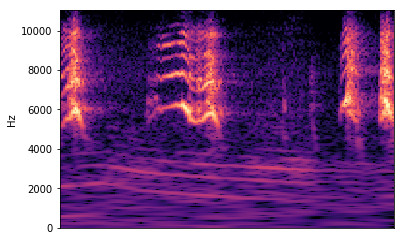

In [15]:
librosa.display.specshow(tmp_train[1], y_axis='hz')

In [27]:
y_labeled[:20]

array([0., 3., 9., 5., 0., 3., 2., 3., 9., 1., 3., 4., 0., 5., 0., 1., 8.,
       0., 2., 9.])

In [17]:
tmp_train.shape

(6374, 168, 173)

In [19]:
N_labeled = X_labeled.shape[0]
X_labeled_train = np.zeros((N_labeled,FEATS,FRAMES))
for i in range(N_labeled):
    X_labeled_train[i,:,:] = mel_spec(X_labeled[i])

In [53]:
Xltz = X_labeled_train.copy()
# zero out bottom 
trunc_freq = 0
Xltz[:,:trunc_freq,:] = 0
Xltz = Xltz.reshape((Xltz.shape[0],Xltz.shape[1]*Xltz.shape[2]))

In [54]:
params = { }
gs = GridSearchCV(rfc, params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs.fit(Xltz, y_labeled)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.2min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [55]:
# gs.best_params_, 
gs.best_score_

0.5981794538361509

## predicting stuff

In [62]:
N_test = X_test.shape[0]
X_test_cqt = np.zeros((N_test,FEATS,FRAMES))
for i in range(N_test):
    X_test_cqt[i,:,:] = mel_spec(X_test[i])
    
Xtz = X_test_cqt.copy()
# zero out bottom 
Xtz[:,:trunc_freq,:] = 0
Xtz = Xtz.reshape((Xtz.shape[0],Xtz.shape[1]*Xtz.shape[2]))

In [63]:
preds = gs.best_estimator_.predict(Xtz)
util.write_predictions(preds, range(len(preds)), "rf_basic.csv")

In [59]:
X_test.shape

(951, 88200)

In [10]:
import numpy as np
tempograms = np.load("tempograms.npy")

IOError: Failed to interpret file 'tempograms.npy' as a pickle

(2307, 173)